In [1]:
from google.colab import files
upload = files.upload()

Saving ForecastAnalyst_CalgaryDailyEnergyDataset.xlsx to ForecastAnalyst_CalgaryDailyEnergyDataset.xlsx


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler ,LabelEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix ,classification_report
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
warnings.filterwarnings('ignore')

In [3]:
def metrics(y_pred, y_truth):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error)
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)

    R2 = r2_score(y_truth, y_pred)
    print('R2 score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

In [4]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed test set vs predicted energy MWH values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()

In [5]:
df = pd.read_excel('ForecastAnalyst_CalgaryDailyEnergyDataset.xlsx')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1855 entries, 0 to 1854
Data columns (total 97 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  1855 non-null   int64  
 1   Month                 1855 non-null   int64  
 2   Day                   1855 non-null   int64  
 3   Energy                1798 non-null   float64
 4   COVID19               1855 non-null   int64  
 5   HLight                1855 non-null   float64
 6   DLSav                 1855 non-null   int64  
 7   TimeTrend             1855 non-null   int64  
 8   NYDAY                 1855 non-null   int64  
 9   FAMILYDAY             1855 non-null   int64  
 10  GOODFRI               1855 non-null   int64  
 11  EASTERMON             1855 non-null   int64  
 12  VICTORIADAY           1855 non-null   int64  
 13  CANADADAY             1855 non-null   int64  
 14  CIVICHOLIDAY          1855 non-null   int64  
 15  LABOURDAY            

In [7]:
df["Date"] = pd.to_datetime(df["Year"].astype('str') + "/" + df["Month"].astype('str') + "/" + df["Day"].astype('str'))
df

,Year,Month,Day,Energy,COVID19,HLight,DLSav,TimeTrend,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,...,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKDAY,YR2017_WKEND,YR2018_2019_WKDAY,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date
0,2017,1,1,1106.217621,0,8.002210,0,731,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,0,1,0,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,2017-01-01
1,2017,1,2,1227.007587,0,8.022236,0,732,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1106.217621,0,1,0,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,2017-01-02
2,2017,1,3,1317.794971,0,8.043889,0,733,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1227.007587,1,0,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,2017-01-03
3,2017,1,4,1298.445827,0,8.067144,0,734,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1317.794971,1,0,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,2017-01-04
4,2017,1,5,1276.709114,0,8.091976,0,735,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1298.445827,1,0,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,2017-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,2022,1,25,NaN,1,8.860260,0,2581,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,0,0,0,0.092500,1.018500,4.074167,1.666667,0,2022-01-25
1851,2022,1,26,NaN,1,8.910327,0,2582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,0,0,0,1.203667,1.296333,5.555667,2.870333,0,2022-01-26
1852,2022,1,27,NaN,1,8.961228,0,2583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,0,0,0,2.407500,3.148167,4.074167,1.388833,0,2022-01-27
1853,2022,1,28,NaN,1,9.012930,0,2584,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,0,0,0,0.740833,3.240833,5.000000,2.499833,0,2022-01-28


In [8]:
df['YR2017_2022_WKDAY'] = df['YR2017_WKDAY'] + df['YR2018_2019_WKDAY']

In [9]:
df.drop(['TimeTrend', 'YR2017_WKDAY','YR2018_2019_WKDAY'], axis=1, inplace=True)

In [10]:
df.tail()

,Year,Month,Day,Energy,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,...,FriJun,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date,YR2017_2022_WKDAY
1850,2022,1,25,NaN,1,8.860260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0.092500,1.018500,4.074167,1.666667,0,2022-01-25,1
1851,2022,1,26,NaN,1,8.910327,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,1.203667,1.296333,5.555667,2.870333,0,2022-01-26,1
1852,2022,1,27,NaN,1,8.961228,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,2.407500,3.148167,4.074167,1.388833,0,2022-01-27,1
1853,2022,1,28,NaN,1,9.012930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0.740833,3.240833,5.000000,2.499833,0,2022-01-28,1
1854,2022,1,29,NaN,1,9.065400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,1,0,0,0.370333,-0.555667,0.092333,-1.574167,0,2022-01-29,0


In [11]:
df_Forcast = df.loc[df.Year == 2022]

In [12]:
df_train = df.loc[df.Year != 2022]

In [13]:
df_train

,Year,Month,Day,Energy,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,...,FriJun,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date,YR2017_2022_WKDAY
0,2017,1,1,1106.217621,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,2017-01-01,0
1,2017,1,2,1227.007587,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,2017-01-02,0
2,2017,1,3,1317.794971,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,2017-01-03,1
3,2017,1,4,1298.445827,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,2017-01-04,1
4,2017,1,5,1276.709114,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,2017-01-05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2021,12,27,1322.970565,1,7.926471,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.989041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1253.152878,0,0,0,0,-30.740500,-31.018667,-28.518333,-29.814667,1,2021-12-27,1
1822,2021,12,28,1328.450487,1,7.937664,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.991781,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1322.970565,0,0,0,0,-27.685333,-23.055500,-16.759333,-20.833333,1,2021-12-28,1
1823,2021,12,29,1343.616512,1,7.950586,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.994521,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1328.450487,0,0,0,0,-23.703500,-24.907333,-22.222167,-22.592500,1,2021-12-29,1
1824,2021,12,30,1320.763027,1,7.965222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.997260,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1343.616512,0,0,0,0,-17.870167,-17.592333,-18.889000,-22.037000,1,2021-12-30,1


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 96 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Year                  1826 non-null   int64         
 1   Month                 1826 non-null   int64         
 2   Day                   1826 non-null   int64         
 3   Energy                1798 non-null   float64       
 4   COVID19               1826 non-null   int64         
 5   HLight                1826 non-null   float64       
 6   DLSav                 1826 non-null   int64         
 7   NYDAY                 1826 non-null   int64         
 8   FAMILYDAY             1826 non-null   int64         
 9   GOODFRI               1826 non-null   int64         
 10  EASTERMON             1826 non-null   int64         
 11  VICTORIADAY           1826 non-null   int64         
 12  CANADADAY             1826 non-null   int64         
 13  CIVICHOLIDAY      

###Dealing with Null values
instead of dropping the Null values we can fill them with the mean of each weeks energy value since we are observing a weekly seasonality.
we first add the week of month column to use it in out apply fuction later.


In [15]:
df_train.index = df_train['Date']
df_Forcast.index = df_Forcast['Date']

In [16]:
import math
def add_week_of_month(df):
    df['week_in_month'] = pd.to_numeric(df.index.day/7)
    df['week_in_month'] = df['week_in_month'].apply(lambda x: math.ceil(x))
    return df
add_week_of_month(df_train)

,Year,Month,Day,Energy,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,...,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date,YR2017_2022_WKDAY,week_in_month
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017,1,1,1106.217621,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,2017-01-01,0,1
2017-01-02,2017,1,2,1227.007587,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,2017-01-02,0,1
2017-01-03,2017,1,3,1317.794971,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,2017-01-03,1,1
2017-01-04,2017,1,4,1298.445827,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,2017-01-04,1,1
2017-01-05,2017,1,5,1276.709114,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,2017-01-05,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2021,12,27,1322.970565,1,7.926471,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.989041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1253.152878,0,0,0,0,-30.740500,-31.018667,-28.518333,-29.814667,1,2021-12-27,1,4
2021-12-28,2021,12,28,1328.450487,1,7.937664,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.991781,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1322.970565,0,0,0,0,-27.685333,-23.055500,-16.759333,-20.833333,1,2021-12-28,1,4
2021-12-29,2021,12,29,1343.616512,1,7.950586,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.994521,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1328.450487,0,0,0,0,-23.703500,-24.907333,-22.222167,-22.592500,1,2021-12-29,1,5


In [17]:
df_train.head(10)

,Year,Month,Day,Energy,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,...,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date,YR2017_2022_WKDAY,week_in_month
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017,1,1,1106.217621,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,2017-01-01,0,1
2017-01-02,2017,1,2,1227.007587,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,2017-01-02,0,1
2017-01-03,2017,1,3,1317.794971,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,2017-01-03,1,1
2017-01-04,2017,1,4,1298.445827,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,2017-01-04,1,1
2017-01-05,2017,1,5,1276.709114,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,2017-01-05,1,1
2017-01-06,2017,1,6,1281.696998,0,8.118355,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1276.709114,0,0,0,0,-12.333333,-14.050000,-15.366667,-15.683334,0,2017-01-06,1,1
2017-01-07,2017,1,7,1220.852929,0,8.146253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1281.696998,1,0,0,0,-16.583333,-16.300001,-16.033334,-17.200001,0,2017-01-07,0,1
2017-01-08,2017,1,8,1222.755134,0,8.175640,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1220.852929,1,0,1,1,-18.049999,-18.499999,-18.149999,-19.316666,0,2017-01-08,0,2
2017-01-09,2017,1,9,1340.461262,0,8.206482,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1222.755134,0,0,0,0,-21.133334,-22.316667,-20.850000,-20.283333,0,2017-01-09,1,2


In [18]:
df_train['Energy'] = df_train.groupby(['Year','Month', 'week_in_month'])['Energy'].apply(lambda x:x.fillna(x.mean()))

In [19]:
# df_train.dropna(inplace=True)

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Data columns (total 97 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Year                  1826 non-null   int64         
 1   Month                 1826 non-null   int64         
 2   Day                   1826 non-null   int64         
 3   Energy                1826 non-null   float64       
 4   COVID19               1826 non-null   int64         
 5   HLight                1826 non-null   float64       
 6   DLSav                 1826 non-null   int64         
 7   NYDAY                 1826 non-null   int64         
 8   FAMILYDAY             1826 non-null   int64         
 9   GOODFRI               1826 non-null   int64         
 10  EASTERMON             1826 non-null   int64         
 11  VICTORIADAY           1826 non-null   int64         
 12  CANADADAY             1826 non-null   int64         
 13  

In [21]:
df_train.loc[df_train.index ==  '2017-03-12']

,Year,Month,Day,Energy,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,...,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date,YR2017_2022_WKDAY,week_in_month
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-12,2017,3,12,1237.855958,0,11.659044,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1189.493429,1,0,1,1,-16.580001,-17.416667,-13.25,-14.366667,0,2017-03-12,0,2


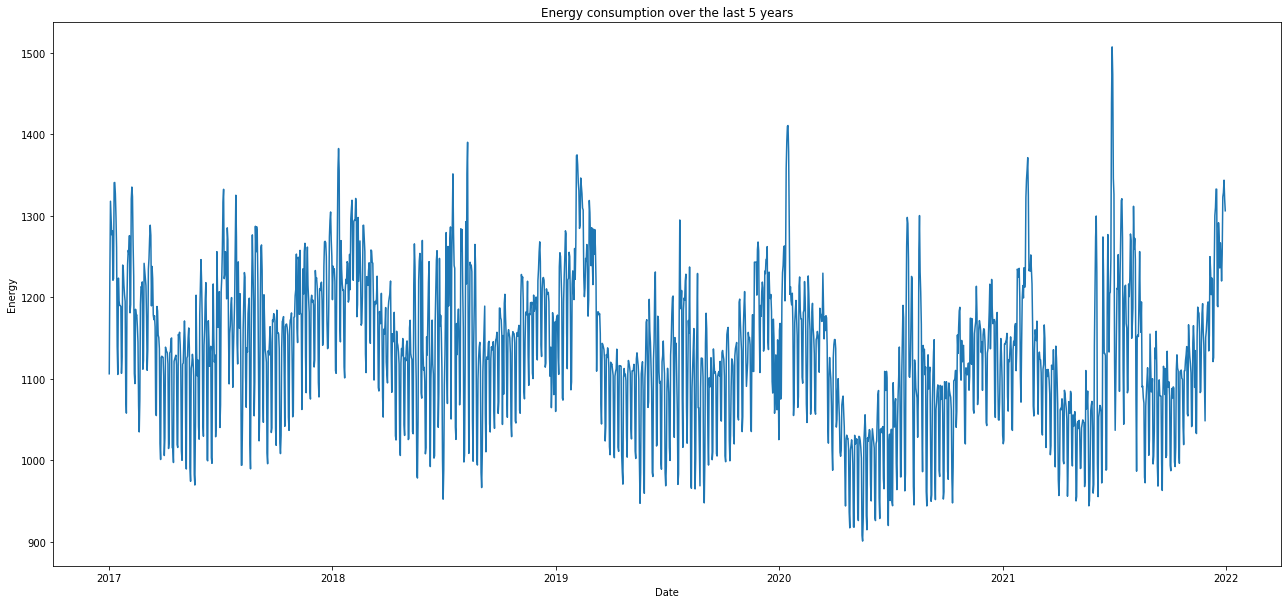

In [22]:
plt.figure(figsize=(22,10))
plt.plot(df_train.Date,df_train.Energy)

plt.title("Energy consumption over the last 5 years")
plt.xlabel("Date")
plt.ylabel("Energy")
plt.show()

As you can see, we have Energy measurement from 2017 to 2021.
Energy consumption ossilates between 950 and 1500.
consumption of winter months is higher then decrease and increases again in midyear and the deacreses and increase again as we get closer to the end of year.

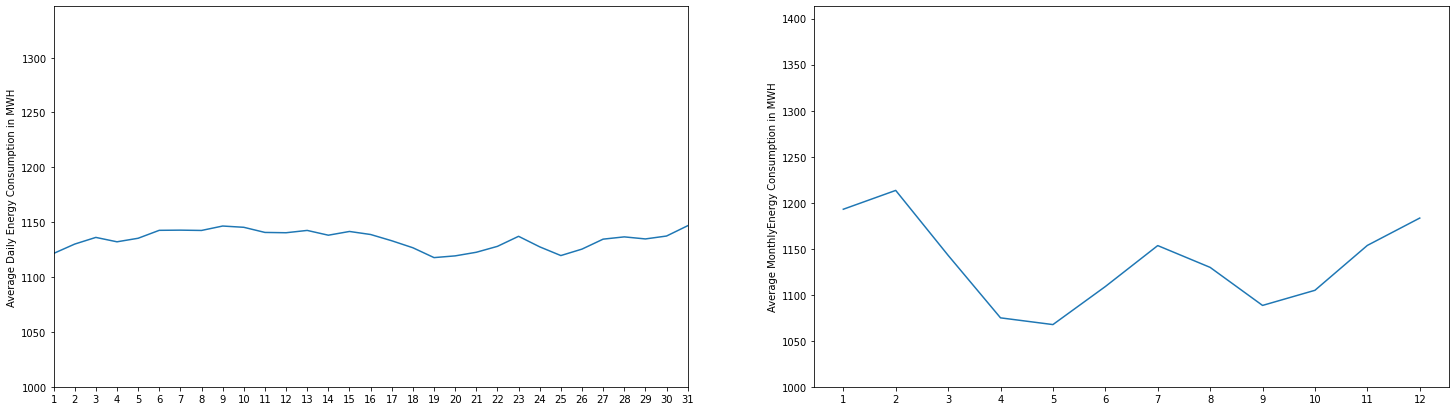

In [23]:
#Average hourly energy consumption observed over the entire period.
x1 = df_train.groupby('Day')['Energy'].mean()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(25,7))
ax1.plot(x1)
ax1.set_ylabel('Average Daily Energy Consumption in MWH')
ax1.set_ylim([1000, max(df_train.groupby('Day')['Energy'].mean())+200])
ax1.set_xlim([1, 30])
ax1.set_xticks(df_train['Day'].unique())

x2 = df_train.groupby('Month')['Energy'].mean()
ax2.plot(x2)
ax2.set_ylabel('Average MonthlyEnergy Consumption in MWH')
ax2.set_ylim([1000, max(df_train.groupby('Month')['Energy'].mean())+200])
ax2.set_xticks(df_train['Month'].unique())

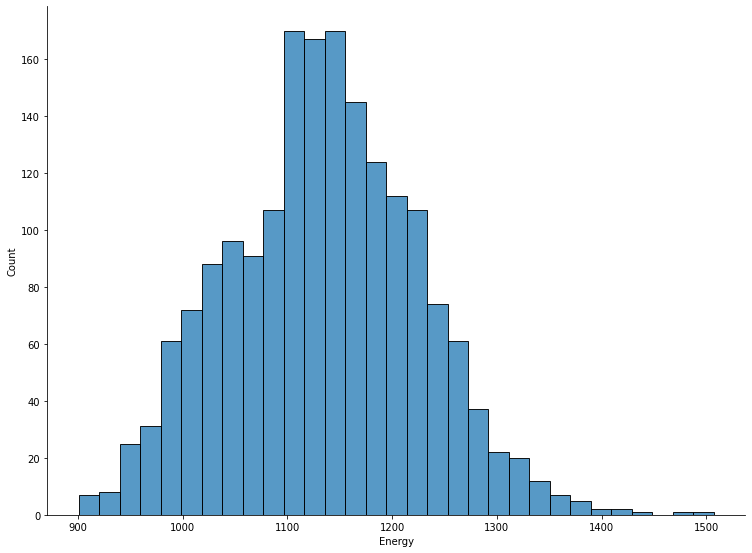

In [24]:
sns.displot(df_train['Energy'] )
plt.gcf().set_size_inches(11.7, 8.27)



   It can be observed that most of the days (2017-2021) have energy consumption between ~1000 to ~1250 MWH and the maximum consumption is around ~1500MWH.



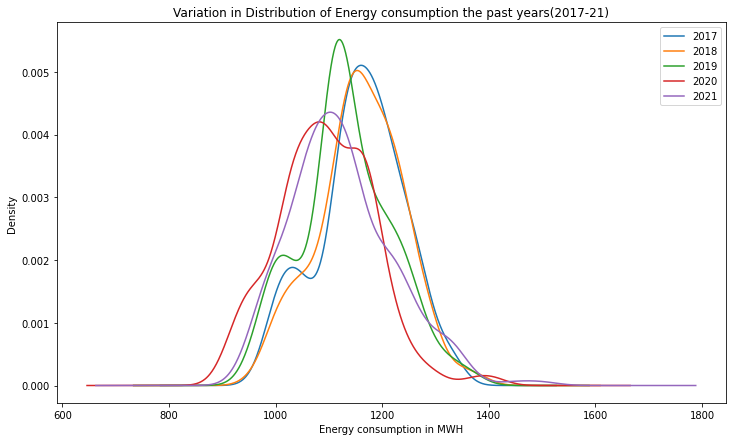

In [25]:
for year in df_train['Year'].unique():
  df_train.loc[df_train.Year == year]['Energy'].plot(kind = 'density',  figsize = (12,7), legend = True, label = year)
  plt.xlabel('Energy consumption in MWH')
  plt.title('Variation in Distribution of Energy consumption the past years(2017-21)')


*** Distribution looks to be bi-modal for all the years and the mean values 
for energy consumption slowly shift towards left (towards lower energy load) each year from 2017 to 2021.

*** There could be many reasons for this shift however it can be presumed to be caused by increasing renewable energy installations and increasing awareness of customers about consumption response programs resulting in a lower energy consumption.

In [26]:
np.arange(1,13)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

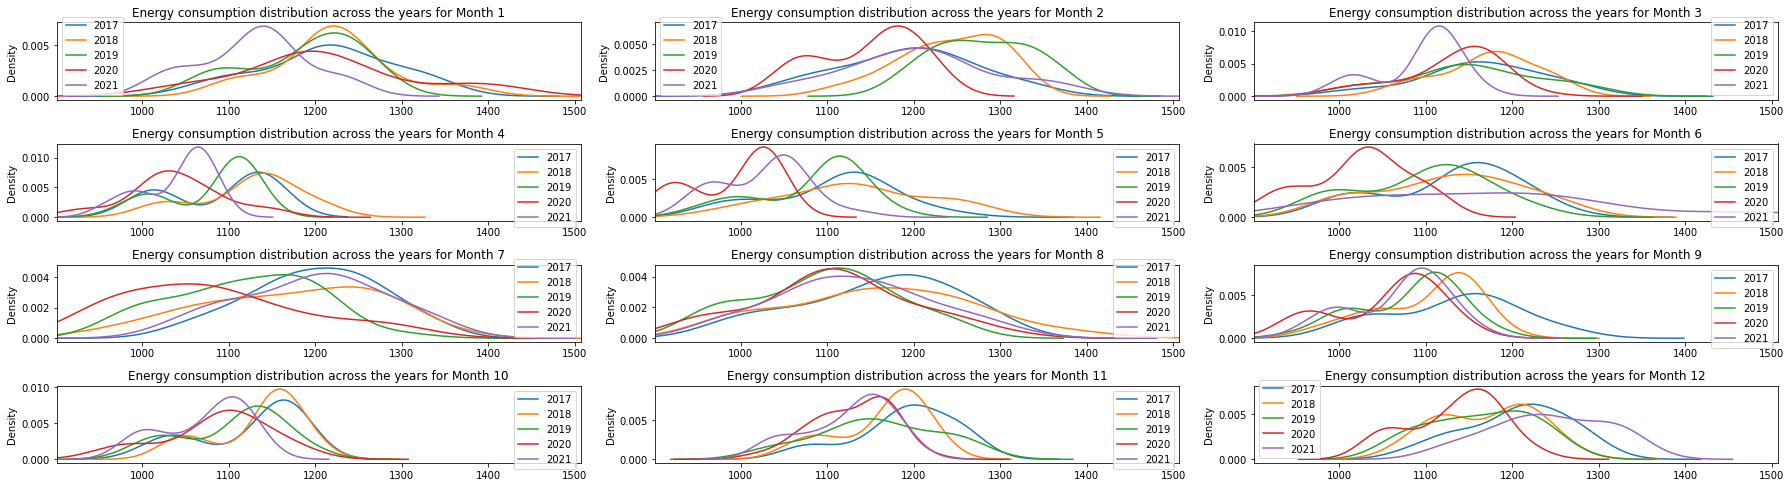

In [27]:
f = plt.figure(figsize = (25,10))
months = np.arange(1,13) 
for i, month in enumerate(months):
    ax = f.add_subplot(6,3,i+1)
    for j, year in enumerate(df_train['Year'].unique()):
        df_train[(df_train['Year'] == year) & (df_train['Month'] == month)]['Energy'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)
    plt.title('Energy consumption distribution across the years for Month '+str(month))
    plt.xlim(np.min(df_train.Energy.values), np.max(df_train.Energy.values))
plt.tight_layout()

The energy consumption values can also be expected to depend on it’s previous lagged values because the energy consumption of a region shouldn’t be expected to change much in the next few hours except for any unexpected or unfortunate events.AIL growth has entered a relatively slow and
steady growth phase due to a number of factors. The Alberta economy is expected to maintain a
slightly downward trend for electricity intensity, as established sectors of the economy (e.g., bitumen
production, manufacturing) improve their energy efficiency and new incoming industries are less
energy intensive. 

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [29]:
def acf_pacf_plots(ts, lags, figsize = (12,8)):
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = figsize)
    
    # Plot the ACF of ts
    _ = plot_acf(ts, lags = lags, zero = False, ax = ax1, alpha = 0.05)

    # Plot the PACF of ts
    _ = plot_pacf(ts, lags = lags, zero = False, ax = ax2, alpha = 0.05)

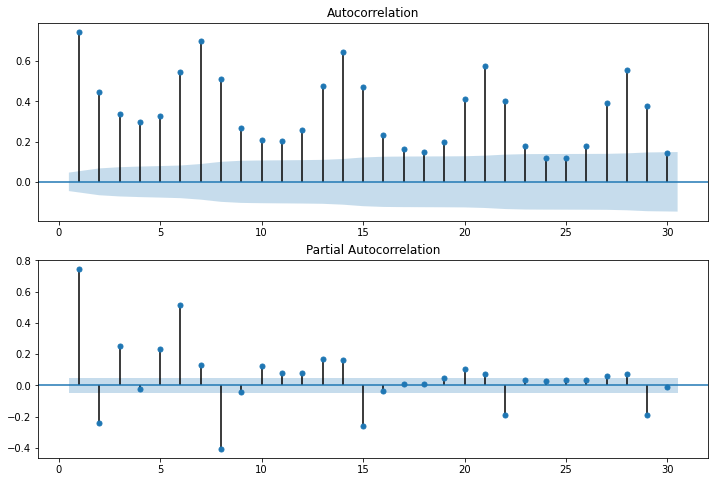

In [30]:
dfacf = []
dfacf = df_train['Energy']
lags = 30

acf_pacf_plots(dfacf, lags = lags, figsize = (12,8))

We have many significant values in both ACF and PACF and a weekly Seasonality can easily be seen in the ACF plot, based on this neither MA or AR or ARIMA models would be appropriate to use for prediction.This is a common pitfall of the SARIMAX models. They cannot handle multiple seasonality. And our energy consumption dataset has multiple seasonalities.

### Now let's see if our data is staionary or not. we will use Dickey-Fuller Test: The test results comprise of a Test Statistic and some Critical Values for different confidence levels. If the test statistic is less than the critical value, we can say that time series is stationary.

In [31]:
from statsmodels.tsa.stattools import adfuller
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

In [32]:
check_adfuller(df_train.Energy)

Test statistic:  -4.1933248791661555
p-value:  0.0006762544695034446
Critical Values: {'1%': -3.4339820768018106, '5%': -2.8631443597478143, '10%': -2.567624108684946}


So as you see the P-Value is very small so we fail to reject the null hypothesis which is our data is stationary.




*   Adding fourier series for days and years.






In [33]:
df_train_no_fourier = df_train.copy()

In [34]:
def fourier(df, year, week):
    """
    df: dataframe to add the fourier terms to 
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for 
    sine and 1 for cosine)
    week_k: same as year_k but for weekly periods
    day_k:same as year_k but for daily periods
    """
    
    for k in range(1, year+1):
        # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)

    for k in range(1, week+1):
        
        # week has a period of 7
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)


In [35]:
fourier(df_train, year= 5, week=5)

In [36]:
df_train.head()

,Year,Month,Day,Energy,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,...,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date,YR2017_2022_WKDAY,week_in_month,year_sin1,year_cos1,year_sin2,year_cos2,year_sin3,year_cos3,year_sin4,year_cos4,year_sin5,year_cos5,week_sin1,week_cos1,week_sin2,week_cos2,week_sin3,week_cos3,week_sin4,week_cos4,week_sin5,week_cos5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017,1,1,1106.217621,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,2017-01-01,0,1,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.085906,0.996303,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,0.433884,-0.900969,0.974928,-0.222521
2017-01-02,2017,1,2,1227.007587,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,2017-01-02,0,1,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545,0.171177,0.985240,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-03,2017,1,3,1317.794971,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,2017-01-03,1,1,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769,0.255182,0.966893,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,-0.974928,-0.222521
2017-01-04,2017,1,4,1298.445827,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,2017-01-04,1,1,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360,0.337301,0.941397,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.781831,0.623490,0.433884,-0.900969
2017-01-05,2017,1,5,1276.709114,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,2017-01-05,1,1,0.085906,0.996303,0.171177,0.985240,0.255182,0.966893,0.337301,0.941397,0.416926,0.908940,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,-0.974928,-0.222521,0.781831,0.623490


***
## 6.4. FB Prophet <a name="6.4"></a>
***

In [37]:
df_train_no_fourier.head()

,Year,Month,Day,Energy,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,...,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date,YR2017_2022_WKDAY,week_in_month
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017,1,1,1106.217621,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,2017-01-01,0,1
2017-01-02,2017,1,2,1227.007587,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,2017-01-02,0,1
2017-01-03,2017,1,3,1317.794971,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,2017-01-03,1,1
2017-01-04,2017,1,4,1298.445827,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,2017-01-04,1,1
2017-01-05,2017,1,5,1276.709114,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,2017-01-05,1,1


In [38]:
df_train_p = df_train_no_fourier.drop(['Year', 'Month', 'Day', 'Date'], axis = 1)

In [39]:
x = df_train_p.drop('Energy', axis = 1)

In [40]:
y = df_train_p['Energy']

In [41]:
def train_test(data, test_size = 0.15):
    """
         train-test split with respect to time series structure
        
        - data: dataframe with variables X_n to train on and the dependent output y which is the column 'Energy'
        - test_size: size of test set
    """
    df = data.copy()
    # get the index after which test set starts
    test_index = int(len(df)*(1-test_size))
        
    X_train = df.drop('Energy', axis = 1).iloc[:test_index]
    y_train = df.Energy.iloc[:test_index]
    X_test = df.drop('Energy', axis = 1).iloc[test_index:]
    y_test = df.Energy.iloc[test_index:]

    return X_train, X_test, y_train, y_test

In [94]:
X_trainP, X_testP, y_trainP, y_testP = train_test(df_train_p, test_size=0.1)

In [95]:
def data_prophet(X_train, X_test, y_train, y_test):
    data_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
    data_train = data_train.reset_index().rename(columns = {'Energy':'y', 'Date':'ds'})
    data_test = pd.merge(X_test, y_test, left_index=True, right_index=True)
    data_test  = data_test.reset_index().rename(columns = {'Energy':'y', 'Date':'ds'})
    return data_train, data_test

In [129]:
data_train, data_test = data_prophet(X_trainP, X_testP, y_trainP, y_testP)

In [130]:
data_train

,ds,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,MonJan,MonFeb,MonMar,...,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,YR2017_2022_WKDAY,week_in_month,y
0,2017-01-01,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,0,1,1106.217621
1,2017-01-02,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,0,1,1227.007587
2,2017-01-03,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,1,1,1317.794971
3,2017-01-04,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,1,1,1298.445827
4,2017-01-05,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,1,1,1276.709114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,2021-06-27,1,16.528090,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1206.308791,0,1,1,1,19.259333,21.944500,28.888833,26.852000,0,0,4,1248.474711
1639,2021-06-28,1,16.516918,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1248.474711,0,0,0,0,18.796333,22.037000,32.592667,30.925833,0,1,4,1438.390187
1640,2021-06-29,1,16.504155,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438.390187,0,0,0,0,21.388833,25.463000,34.722167,31.388833,0,1,5,1507.006187
1641,2021-06-30,1,16.489815,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1507.006187,0,0,0,0,21.296167,25.000167,34.629667,31.018667,0,1,5,1473.011464


In [98]:
data_test

,ds,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,MonJan,MonFeb,MonMar,...,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,YR2017_2022_WKDAY,week_in_month,y
0,2021-07-02,1,16.456476,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1345.835793,0,0,0,0,25.370333,23.889000,26.666667,16.296333,0,1,1,1326.252778
1,2021-07-03,1,16.437513,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1326.252778,0,1,0,0,16.388833,18.055833,23.611167,22.685167,0,0,1,1121.370640
2,2021-07-04,1,16.417049,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1121.370640,0,1,1,1,16.759167,16.018667,17.129667,14.722167,0,0,1,1036.905814
3,2021-07-05,1,16.395105,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1036.905814,0,0,0,0,13.333000,14.074000,16.666833,16.296500,0,1,1,1099.404895
4,2021-07-06,1,16.371706,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1099.404895,0,0,0,0,14.722167,15.092500,21.296167,20.092667,0,1,1,1152.795105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2021-12-27,1,7.926471,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.989041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1253.152878,0,0,0,0,-30.740500,-31.018667,-28.518333,-29.814667,1,1,4,1322.970565
179,2021-12-28,1,7.937664,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.991781,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1322.970565,0,0,0,0,-27.685333,-23.055500,-16.759333,-20.833333,1,1,4,1328.450487
180,2021-12-29,1,7.950586,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.994521,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1328.450487,0,0,0,0,-23.703500,-24.907333,-22.222167,-22.592500,1,1,5,1343.616512
181,2021-12-30,1,7.965222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.997260,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1343.616512,0,0,0,0,-17.870167,-17.592333,-18.889000,-22.037000,1,1,5,1320.763027


In [99]:
from fbprophet import Prophet
prop = Prophet(interval_width = 0.95)

In [100]:
prop.add_regressor('DLSav')
prop.add_regressor('YR2018_2019_WKEND')
prop.add_regressor('YR2017_2022_WKDAY') #'auto'=> standardize if not
prop.add_regressor('NightDB')
prop.add_regressor('MornDB')
prop.add_regressor('AfterDB')
prop.add_regressor('EvenDB')
prop.add_regressor('Sun_Hol')
prop.add_regressor('Sunday')
prop.add_regressor('ChristmasLightsTrend')

In [101]:
data_train

,ds,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,MonJan,MonFeb,MonMar,...,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,YR2017_2022_WKDAY,week_in_month,y
0,2017-01-01,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,0,1,1106.217621
1,2017-01-02,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,0,1,1227.007587
2,2017-01-03,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,1,1,1317.794971
3,2017-01-04,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,1,1,1298.445827
4,2017-01-05,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,1,1,1276.709114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,2021-06-27,1,16.528090,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1206.308791,0,1,1,1,19.259333,21.944500,28.888833,26.852000,0,0,4,1248.474711
1639,2021-06-28,1,16.516918,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1248.474711,0,0,0,0,18.796333,22.037000,32.592667,30.925833,0,1,4,1438.390187
1640,2021-06-29,1,16.504155,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1438.390187,0,0,0,0,21.388833,25.463000,34.722167,31.388833,0,1,5,1507.006187
1641,2021-06-30,1,16.489815,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1507.006187,0,0,0,0,21.296167,25.000167,34.629667,31.018667,0,1,5,1473.011464


In [102]:
prop.fit(data_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [103]:
future_dates = prop.make_future_dataframe(periods=len(data_test), freq='D', include_history=True)
# Aadding regressors 
future_dates = pd.merge(future_dates, (data_train.append(data_test)).drop('y', axis=1), on = 'ds')

In [104]:
future_dates

,ds,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,MonJan,MonFeb,MonMar,...,FriJun,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,YR2017_2022_WKDAY,week_in_month
0,2017-01-01,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,0,1
1,2017-01-02,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,0,1
2,2017-01-03,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,1,1
3,2017-01-04,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,1,1
4,2017-01-05,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2021-12-27,1,7.926471,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.989041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1253.152878,0,0,0,0,-30.740500,-31.018667,-28.518333,-29.814667,1,1,4
1822,2021-12-28,1,7.937664,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.991781,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1322.970565,0,0,0,0,-27.685333,-23.055500,-16.759333,-20.833333,1,1,4
1823,2021-12-29,1,7.950586,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.994521,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1328.450487,0,0,0,0,-23.703500,-24.907333,-22.222167,-22.592500,1,1,5
1824,2021-12-30,1,7.965222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.997260,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1343.616512,0,0,0,0,-17.870167,-17.592333,-18.889000,-22.037000,1,1,5


In [105]:
forecast = prop.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-01,1131.949310,1043.078140,1219.941709
1,2017-01-02,1181.562552,1095.502982,1270.197960
2,2017-01-03,1278.974534,1194.464865,1372.510498
3,2017-01-04,1261.274625,1165.506347,1353.531241
4,2017-01-05,1250.410129,1153.971463,1340.953828


In [106]:
metrics(forecast.yhat, df_train_p.Energy)

RMSE or Root mean squared error: 49.04
R2 score: 0.71
Mean Absolute Error: 35.24


In [110]:
prop.predict(data_train.drop('y', axis=1)).yhat

0       1131.949310
1       1181.562552
2       1278.974534
3       1261.274625
4       1250.410129
           ...     
1638    1026.682003
1639    1143.180326
1640    1141.905377
1641    1147.928026
1642    1061.071447
Name: yhat, Length: 1643, dtype: float64

In [137]:
data_trainn = data_train.copy()

In [138]:
data_trainn.index = data_train.ds

In [139]:
y_p = data_trainn['y']

In [143]:
pred = prop.predict(data_train.drop('y', axis=1)).yhat

In [144]:
pred.index = data_train.ds

In [146]:
plot_ts_pred(y_p, pred, model_name='FB Prophet on Training set')

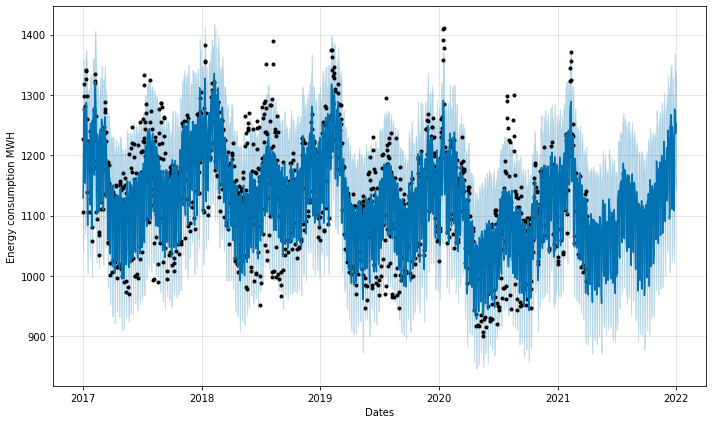

In [55]:
_ = prop.plot(forecast, uncertainty = True, xlabel = 'Dates', ylabel = 'Energy consumption MWH')

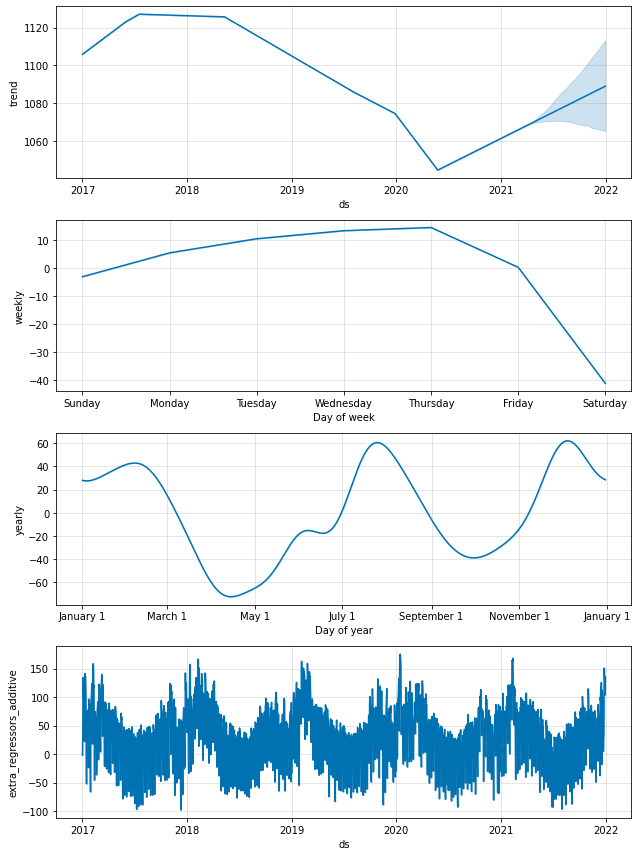

In [56]:
_ = prop.plot_components(forecast)

In [57]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(prop, horizon='30 days')
df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Making 78 forecasts with cutoffs between 2018-01-02 00:00:00 and 2021-03-02 00:00:00


  0%|          | 0/78 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,2334.404559,48.315676,36.602757,0.032825,0.026271,0.910256
1,4 days,1939.800706,44.043169,34.812765,0.031433,0.025697,0.944444
2,5 days,1840.587379,42.902067,34.809354,0.031300,0.027318,0.961538
3,6 days,1883.997287,43.405038,36.270585,0.032193,0.028192,0.948718
4,7 days,2401.912860,49.009314,40.634229,0.035674,0.033197,0.905983
5,8 days,2711.478180,52.071856,41.315670,0.036058,0.029757,0.876068
6,9 days,3083.673179,55.530831,41.913074,0.036478,0.027690,0.863248
7,10 days,3186.915533,56.452773,39.853284,0.034595,0.024590,0.867521
8,11 days,3176.526346,56.360681,40.182169,0.035052,0.025654,0.867521
9,12 days,2982.754861,54.614603,39.796070,0.034962,0.027084,0.871795


In [58]:
import xgboost as xgb

In [59]:
df_train

,Year,Month,Day,Energy,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,...,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date,YR2017_2022_WKDAY,week_in_month,year_sin1,year_cos1,year_sin2,year_cos2,year_sin3,year_cos3,year_sin4,year_cos4,year_sin5,year_cos5,week_sin1,week_cos1,week_sin2,week_cos2,week_sin3,week_cos3,week_sin4,week_cos4,week_sin5,week_cos5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017,1,1,1106.217621,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,2017-01-01,0,1,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.085906,0.996303,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,0.433884,-0.900969,0.974928,-0.222521
2017-01-02,2017,1,2,1227.007587,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,2017-01-02,0,1,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545,0.171177,0.985240,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-03,2017,1,3,1317.794971,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,2017-01-03,1,1,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769,0.255182,0.966893,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,-0.974928,-0.222521
2017-01-04,2017,1,4,1298.445827,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,2017-01-04,1,1,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360,0.337301,0.941397,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.781831,0.623490,0.433884,-0.900969
2017-01-05,2017,1,5,1276.709114,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,2017-01-05,1,1,0.085906,0.996303,0.171177,0.985240,0.255182,0.966893,0.337301,0.941397,0.416926,0.908940,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,-0.974928,-0.222521,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2021,12,27,1322.970565,1,7.926471,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.989041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1253.152878,0,0,0,0,-30.740500,-31.018667,-28.518333,-29.814667,1,2021-12-27,1,4,-0.073045,0.997329,-0.145700,0.989329,-0.217577,0.976043,-0.288291,0.957543,-0.357464,0.933927,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2021-12-28,2021,12,28,1328.450487,1,7.937664,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.991781,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1322.970565,0,0,0,0,-27.685333,-23.055500,-16.759333,-20.833333,1,2021-12-28,1,4,-0.055879,0.998438,-0.111583,0.993755,-0.166938,0.985967,-0.221772,0.975099,-0.275913,0.961183,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,-0.974928,-0.222521
2021-12-29,2021,12,29,1343.616512,

In [85]:
X_train, X_test, y_train, y_test = train_test(df_train, test_size=0.10)

In [86]:
X_train

,Year,Month,Day,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,MonJan,...,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date,YR2017_2022_WKDAY,week_in_month,year_sin1,year_cos1,year_sin2,year_cos2,year_sin3,year_cos3,year_sin4,year_cos4,year_sin5,year_cos5,week_sin1,week_cos1,week_sin2,week_cos2,week_sin3,week_cos3,week_sin4,week_cos4,week_sin5,week_cos5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017,1,1,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,2017-01-01,0,1,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.085906,0.996303,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,0.433884,-0.900969,0.974928,-0.222521
2017-01-02,2017,1,2,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,2017-01-02,0,1,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545,0.171177,0.985240,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-03,2017,1,3,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,2017-01-03,1,1,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,0.978769,0.255182,0.966893,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,-0.974928,-0.222521
2017-01-04,2017,1,4,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,2017-01-04,1,1,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,0.962360,0.337301,0.941397,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.781831,0.623490,0.433884,-0.900969
2017-01-05,2017,1,5,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,2017-01-05,1,1,0.085906,0.996303,0.171177,0.985240,0.255182,0.966893,0.337301,0.941397,0.416926,0.908940,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,-0.974928,-0.222521,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-27,2021,6,27,1,16.528090,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1206.308791,0,1,1,1,19.259333,21.944500,28.888833,26.852000,0,2021-06-27,0,4,0.079477,-0.996837,-0.158452,0.987367,0.236424,-0.971650,-0.312900,0.949786,0.387397,-0.921913,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,0.433884,-0.900969,0.974928,-0.222521
2021-06-28,2021,6,28,1,16.516918,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1248.474711,0,0,0,0,18.796333,22.037000,32.592667,30.925833,0,2021-06-28,1,4,0.062318,-0.998056,-0.124395,0.992233,0.185987,-0.982552,-0.246857,0.969052,0.306767,-0.951785,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2021-06-29,2021,6,29,1,16.504155,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1438.390187,0,0,0,0,21.

In [87]:
X_test.drop('Date', axis = 1, inplace = True)
X_train.drop('Date', axis = 1, inplace = True)

In [62]:
X_test

,Year,Month,Day,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,MonJan,...,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,YR2017_2022_WKDAY,week_in_month,year_sin1,year_cos1,year_sin2,year_cos2,year_sin3,year_cos3,year_sin4,year_cos4,year_sin5,year_cos5,week_sin1,week_cos1,week_sin2,week_cos2,week_sin3,week_cos3,week_sin4,week_cos4,week_sin5,week_cos5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-02,2021,7,2,1,16.456476,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1345.835793,0,0,0,0,25.370333,23.889000,26.666667,16.296333,0,1,1,-0.006451,-0.999979,0.012901,0.999917,-0.019352,-0.999813,0.025801,0.999667,-0.032249,-0.999480,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,0.974928,-0.222521,-0.781831,0.623490
2021-07-03,2021,7,3,1,16.437513,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1326.252778,0,1,0,0,16.388833,18.055833,23.611167,22.685167,0,0,1,-0.023651,-0.999720,0.047289,0.998881,-0.070900,-0.997483,0.094472,0.995527,-0.117991,-0.993015,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,-0.781831,0.623490,-0.433884,-0.900969
2021-07-04,2021,7,4,1,16.417049,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1121.370640,0,1,1,1,16.759167,16.018667,17.129667,14.722167,0,0,1,-0.040844,-0.999166,0.081621,0.996663,-0.122261,-0.992498,0.162697,0.986676,-0.202861,-0.979208,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,0.433884,-0.900969,0.974928,-0.222521
2021-07-05,2021,7,5,1,16.395105,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1036.905814,0,0,0,0,13.333000,14.074000,16.666833,16.296500,0,1,1,-0.058026,-0.998315,0.115856,0.993266,-0.173295,-0.984870,0.230151,0.973155,-0.286231,-0.958161,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2021-07-06,2021,7,6,1,16.371706,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1099.404895,0,0,0,0,14.722167,15.092500,21.296167,20.092667,0,1,1,-0.075190,-0.997169,0.149953,0.988693,-0.223868,-0.974619,0.296516,0.955028,-0.367485,-0.930030,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,2021,12,27,1,7.926471,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.989041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1253.152878,0,0,0,0,-30.740500,-31.018667,-28.518333,-29.814667,1,1,4,-0.073045,0.997329,-0.145700,0.989329,-0.217577,0.976043,-0.288291,0.957543,-0.357464,0.933927,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2021-12-28,2021,12,28,1,7.937664,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.991781,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1322.970565,0,0,0,0,-27.685333,-23.055500,-16.759333,-20.833333,1,1,4,-0.055879,0.998438,-0.111583,0.993755,-0.166938,0.985967,-0.221772,0.975099,-0.275913,0.961183,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,-0.974928,-0.222521
2021-12-29,2021,12,29,1,7.950586,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.994521,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1328.4

In [88]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 5, n_estimators = 100, random_state=42)

In [89]:
xg_reg.fit(X_train, y_train)

[23:59:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=5, colsample_bytree=0.3, random_state=42)

In [90]:
_ = metrics(xg_reg.predict(X_train), y_train)

RMSE or Root mean squared error: 16.26
R2 score: 0.97
Mean Absolute Error: 11.23


In [91]:
preds_boost = xg_reg.predict(X_test)

In [92]:
_ = metrics(preds_boost, y_test)

RMSE or Root mean squared error: 22.66
R2 score: 0.94
Mean Absolute Error: 17.82


In [122]:
xg_reg.predict(X_train)

array([1108.5901, 1212.7555, 1287.2632, ..., 1463.5367, 1458.841 ,
       1348.8734], dtype=float32)

In [68]:
plot_ts_pred(y_train, xg_reg.predict(X_train), model_name='XGBoost with Fourier terms on Training set')

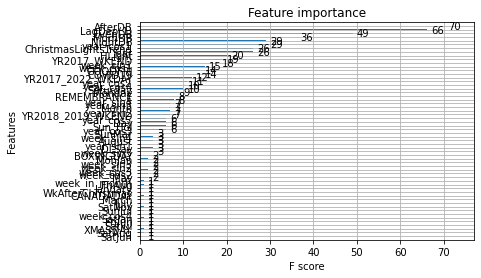

In [69]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 30]

In [70]:
df_Concat = pd.concat([df_train_no_fourier, df_Forcast])

In [71]:
df_Concat

,Year,Month,Day,Energy,COVID19,HLight,DLSav,NYDAY,FAMILYDAY,GOODFRI,EASTERMON,VICTORIADAY,CANADADAY,CIVICHOLIDAY,LABOURDAY,THANKSGIVING,REMEMBRANCE,XMASEVE,XMASDAY,BOXINGDAY,WkBeforeChristmas,WkAfterChristmas,ChristmasLightsTrend,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,January,February,March,April,May,June,July,August,September,October,November,...,FriJul,FriAug,FriSep,FriOct,FriNov,SatJan,SatFeb,SatMar,SatApr,SatMay,SatJun,SatJul,SatAug,SatSep,SatOct,SatNov,SunJan,SunFeb,SunMar,SunApr,SunMay,SunJun,SunJul,SunAug,SunSep,SunOct,SunNov,LagDep(1),YR2017_WKEND,YR2018_2019_WKEND,Sunday,Sun_Hol,NightDB,MornDB,AfterDB,EvenDB,December,Date,YR2017_2022_WKDAY,week_in_month
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2017,1,1,1106.217621,0,8.002210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,1,0,1,1,-10.283333,-12.033333,-12.033333,-14.083333,0,2017-01-01,0,1.0
2017-01-02,2017,1,2,1227.007587,0,8.022236,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1106.217621,1,0,0,1,-20.100000,-22.766667,-17.966667,-18.699999,0,2017-01-02,0,1.0
2017-01-03,2017,1,3,1317.794971,0,8.043889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1227.007587,0,0,0,0,-19.533333,-19.266666,-17.233333,-18.333333,0,2017-01-03,1,1.0
2017-01-04,2017,1,4,1298.445827,0,8.067144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1317.794971,0,0,0,0,-12.316667,-11.300000,-8.700000,-13.983333,0,2017-01-04,1,1.0
2017-01-05,2017,1,5,1276.709114,0,8.091976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1298.445827,0,0,0,0,-11.016667,-6.500000,-4.350000,-8.600000,0,2017-01-05,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,2022,1,25,NaN,1,8.860260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0.092500,1.018500,4.074167,1.666667,0,2022-01-25,1,NaN
2022-01-26,2022,1,26,NaN,1,8.910327,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,1.203667,1.296333,5.555667,2.870333,0,2022-01-26,1,NaN
2022-01-27,2022,1,27,NaN,1,8.961228,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,2.407500,3.148167,4.074167,1.388833,0,2022-01-27,1,NaN


In [72]:
fourier(df_Concat, year= 5, week=5)

In [73]:
df_Concat.drop('Date', axis = 1, inplace = True)

In [74]:
preds_boost = xg_reg.predict(df_Concat.drop('Energy', axis = 1))

In [75]:
plot_ts_pred(df_Concat['Energy'], xg_reg.predict(df_Concat.drop('Energy', axis = 1)), model_name='XGBoost with Fourier terms')